In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [2]:
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Tue Mar 17 14:11:50 2020


In [3]:
import numpy as np
import pandas as pd
import matplotlib

In [4]:
%load_ext cython

In [5]:
fontsize=20
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': fontsize,
        }

plt.rcParams["font.size"     ] = fontsize


In [6]:
from dataclasses import dataclass, field
import abc
from typing import Sequence
from typing import Tuple, List
from typing      import TypeVar

In [7]:
from scipy.stats import nbinom
from scipy.stats import weibull_min
from scipy.stats import norm
from scipy.stats import skewnorm

In [8]:
from c19.histograms import h1, PlotLabels, h1d

In [9]:
from c19.c19stats import c19_nbinom_pdf, c19_nbinom_rvs
from c19.c19stats import weib_pdf, c19_weib_rvs
from c19.c19stats import normal_pdf, normal_rvs
from c19.c19stats import sknormal_pdf, sknormal_rvs

# Statistical distributions

## Negative binomial distribution

- The Negative binomial distribution is used to draw the secondary number of infections, given the reproductive number $R_0$ and the heterogeneity parameter k. The 'individual reproductive number', $R_0$, is a random variable representing the expected number of secondary cases caused by a particular infected individual. Values for $R_0$ are drawn from a continuous probability distribution with population mean $R_0$ that encodes all variation in infectious histories of individuals, including properties of the host and pathogen and environmental circumstances. In this framework, super-spreading events (SSEs) are not exceptional events, but important realizations from the right-hand tail of a distribution of $R_0$. This is achieved through the heterogeneity parameter k: 

- In  [Lloyd-Smith] (LLoyd-Smith et al, Vol 438|17 November 2005|doi:10.1038/nature04153), it is proposed the use of the negative binomial. The negative binomial model includes the conventional Poisson ($k \rightarrow \infty$) and geometric (k=1) models as special cases. It has variance $R_0(1 + R_0/k)$, so smaller values of k indicate greater heterogeneity. The value proposed in Lloyd-Smith is $k=0.16$.

- The convention used in [Lloyd-Smith] defines the negative binomial distribution as 
$nbinom'$, such that:
$nbinom'(R_0, k)$, corresponding to $nbinom(k, p)$ with ,
$p = (1 + R_0/k)^{-1}$.


## Weibull distribution

- The Weibull distribution is used to draw the time series for each individual story. The definition corresponds to $weib'(\mu, \sigma) = weib(\sigma, \mu)$, where the mean value of the relevant time period (eg, the incubation period) is corresponds to the sacle parameter of the Weibull distribution and the rms ($\sigma$) corresponds to the shaphe parameter. 

# Skewed Normal distribution
- The skewed normal distribution adds a shape parameter to the usual Normal distribution.

## Negative binomial pdf

- Notice that ~70 % of the trials for r0 = 2.5 and k = 0.16 are zero, but tails are very long. While R0 = 2.5 means that in average one person infects 2.5 other persons, the NB distribution is such that in most cases the number of infections are zero but in a few cases it can be very large

In [10]:
def plot_c19_nbinom_pdf(r0, k, figsize=(8,8)):

    fig = plt.figure(figsize=figsize)
    ax=plt.subplot(111)

    x = np.arange(0, 20)
    ax.plot(x, c19_nbinom_pdf(r0, k, x), 'bo', ms=8, label='nbinom pmf')
    ax.vlines(x, 0, c19_nbinom_pdf(r0, k, x), colors='b', lw=5, alpha=0.5)

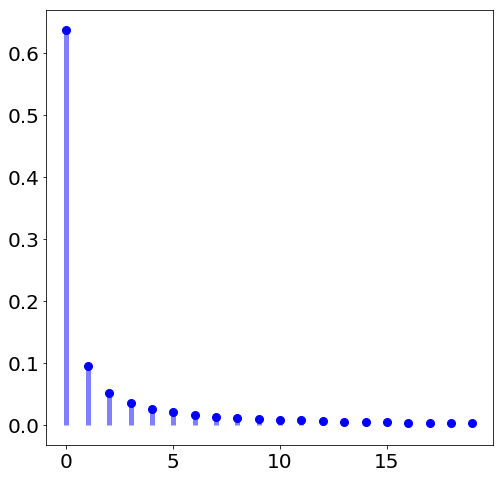

In [11]:
plot_c19_nbinom_pdf(r0=2.5, k=0.16, figsize=(8,8))

In [12]:
def plot_c19_nbinom_pdfs(R0s, Ks, figsize=(8,8), nx=2, ny=2):
    x = np.arange(0, 20)
    fig = plt.figure(figsize=figsize)
    for i, r0 in enumerate(R0s):
        ax      = fig.add_subplot(nx, ny, i+1)
        k = Ks[i]
        ax.plot(x, c19_nbinom_pdf(r0, k, x), 'o', ms=8, label=f'R0 = {r0}, k = {k}')
        plt.xlabel('n', fontsize=20)
        plt.ylabel('Prob(n)')
        plt.legend()
    plt.tight_layout()
    plt.show()

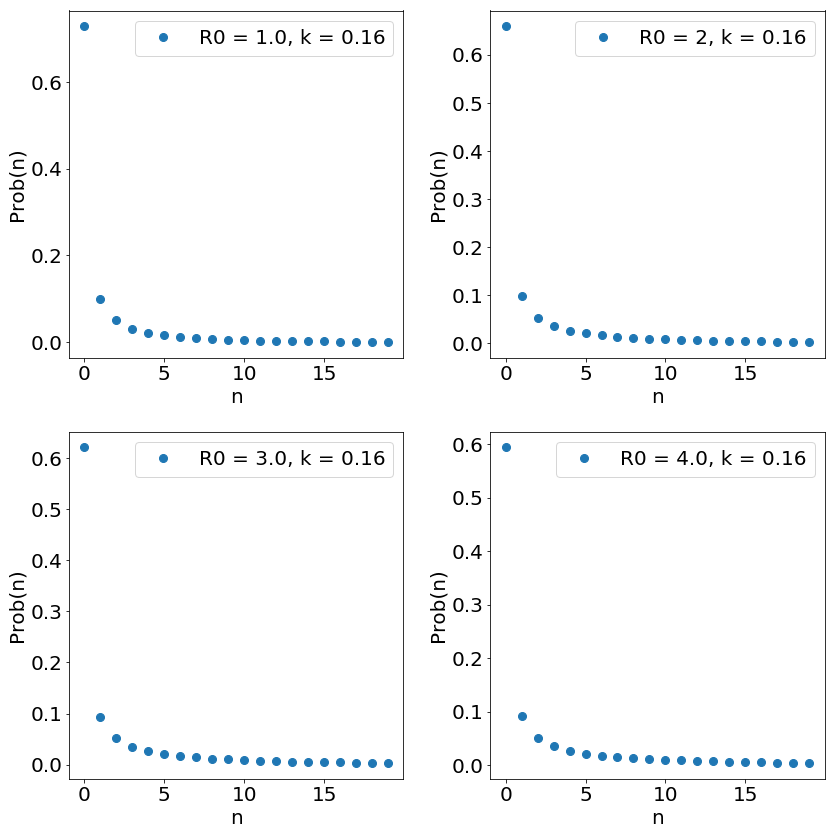

In [13]:
plot_c19_nbinom_pdfs((1., 2, 3., 4.), 4*[0.16], figsize=(12,12), nx=2, ny=2)

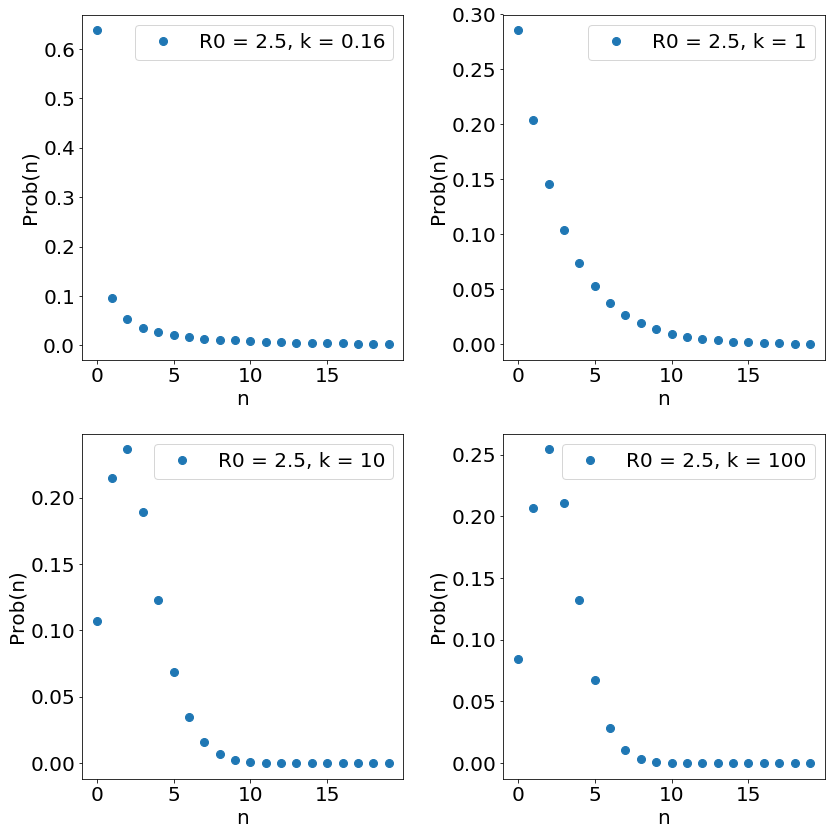

In [14]:
plot_c19_nbinom_pdfs(4*[2.5], (0.16, 1, 10, 100), figsize=(12,12), nx=2, ny=2)

In [15]:
r19 = c19_nbinom_rvs(r0=2.5, k=0.16, size=1000)

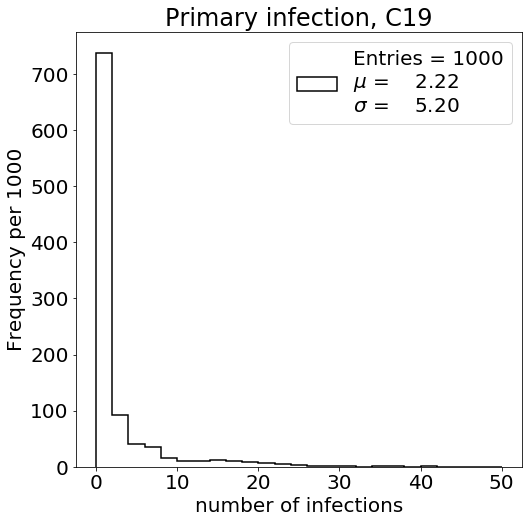

In [16]:
pl = PlotLabels(x="number of infections", y="Frequency per 1000", title="Primary infection, C19")
n, b, mu, std = h1d(r19, bins = 25, range =(0,50), pltLabels=pl, figsize=(8,8))

## Weibull distribution

In [17]:
def plot_weib_pdf(mu, rms, figsize=(8,8)):
    fig = plt.figure(figsize=(8,8))
    ax=plt.subplot(111)
    x=np.linspace(0,15)
    y = weib_pdf(x, mu, rms)
    ax.plot(x, y,'r-', lw=3, alpha=0.6)
    plt.title(f'Weibull PDF, mu={mu}, rms ={rms}')
    plt.show()

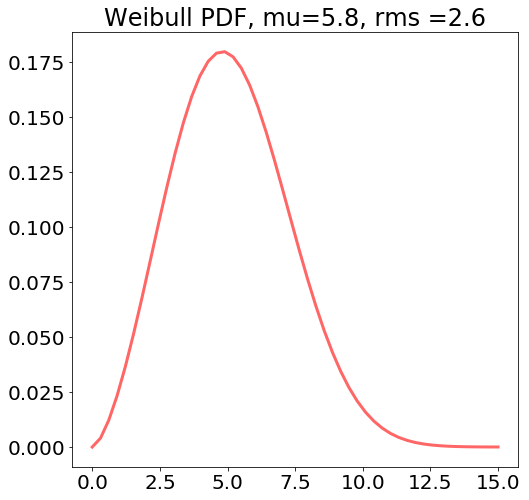

In [18]:
plot_weib_pdf(mu=5.8, rms=2.6)

In [19]:
b19 = c19_weib_rvs(mu=5.8, rms=2.6, size=1000)

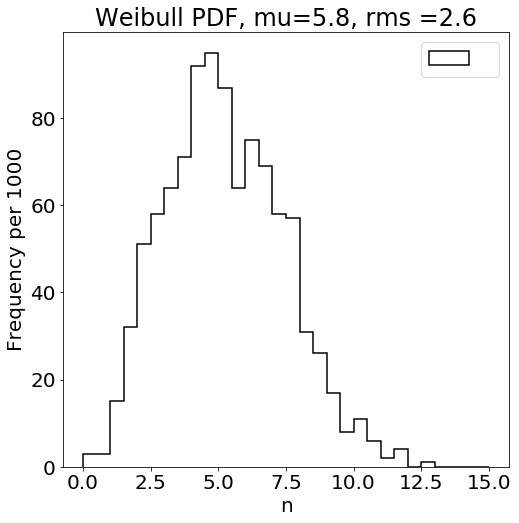

In [20]:
pl = PlotLabels(x="n", y="Frequency per 1000", title=f'Weibull PDF, mu=5.8, rms =2.6')
n, b, mu, std = h1d(b19, bins = 30, range =(0,15), stats=False, pltLabels=pl, figsize=(8,8))

## Normal and skewed normal distributions

In [21]:
def normal_pdf(x,mu,rms):
    return norm.pdf(x, loc=mu, scale=rms)

In [22]:
def plot_normal_pdf(mu, rms, xmin=-5, xmax =15, figsize=(8,8)):
    fig = plt.figure(figsize=(8,8))
    ax=plt.subplot(111)
    x=np.linspace(xmin,xmax,500)
    y = normal_pdf(x,mu,rms)
    ax.plot(x, y,'r-', lw=2, alpha=0.6)
    plt.title(f' Normal PDF, mu={mu}, rms ={rms}')
    plt.show()

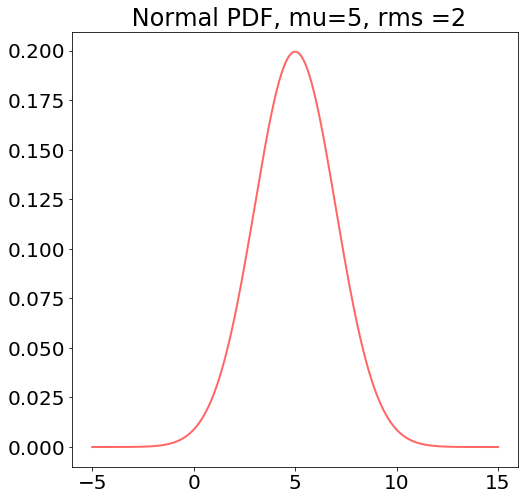

In [23]:
plot_normal_pdf(mu=5, rms=2, xmin=-5, xmax =15, figsize=(8,8))

In [24]:
g19 = normal_rvs(mu=5, sigma=2, size=10000)

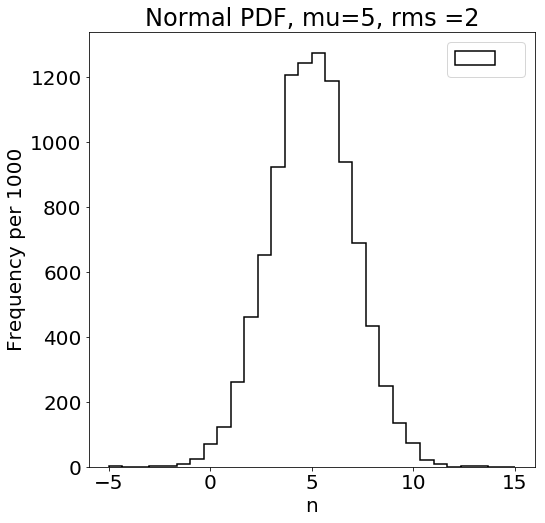

In [25]:
pl = PlotLabels(x="n", y="Frequency per 1000", title=f'Normal PDF, mu=5, rms =2')
n, b, mu, std = h1d(g19, bins = 30, range =(-5,15), pltLabels=pl, stats= False, figsize=(8,8))

In [26]:
def plot_sknormal_pdf(mu, rms, a=(1,2,10), xmin=-5, xmax =15, figsize=(8,8)):
    fig = plt.figure(figsize=(8,8))
    ax=plt.subplot(111)
    x=np.linspace(xmin,xmax,500)
    for al in a:
        y = sknormal_pdf(x,mu,rms, al)
        ax.plot(x, y, lw=2, alpha=0.6, label=f'a={al}')
    ax.legend()
    plt.show()

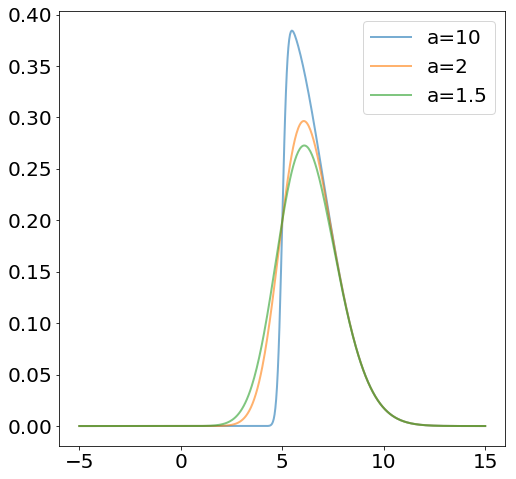

In [27]:
plot_sknormal_pdf(mu=5, rms=2, a=(10,2,1.5))

In [28]:
sk19 = sknormal_rvs(mu=5, sigma=2, a=1.5, size=10000)

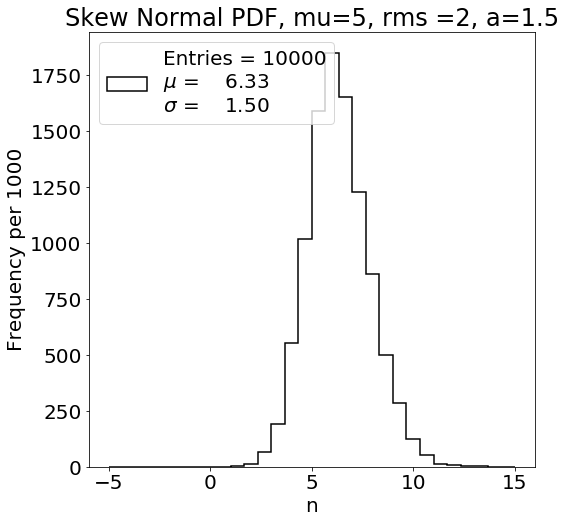

In [29]:
pl = PlotLabels(x="n", y="Frequency per 1000", title=f'Skew Normal PDF, mu=5, rms =2, a=1.5')
n, b, mu, std = h1d(sk19, bins = 30, range =(-5,15), pltLabels=pl, stats= True, 
                    legendloc='upper left', figsize=(8,8))

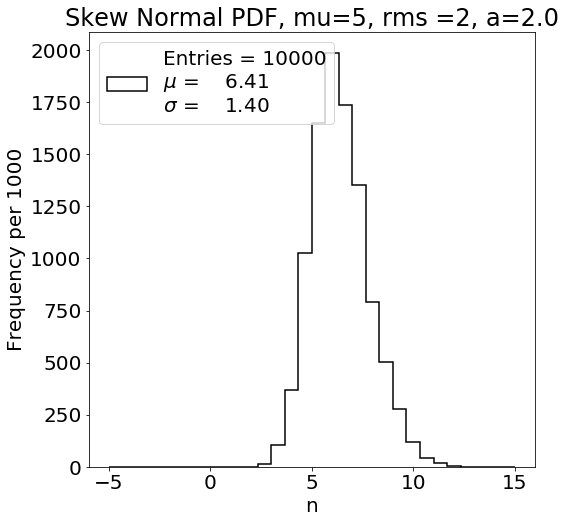

In [30]:
sk19 = sknormal_rvs(mu=5, sigma=2, a=2.0, size=10000)
pl = PlotLabels(x="n", y="Frequency per 1000", title=f'Skew Normal PDF, mu=5, rms =2, a=2.0')
n, b, mu, std = h1d(sk19, bins = 30, range =(-5,15), pltLabels=pl, stats= True, 
                    legendloc='upper left', figsize=(8,8))

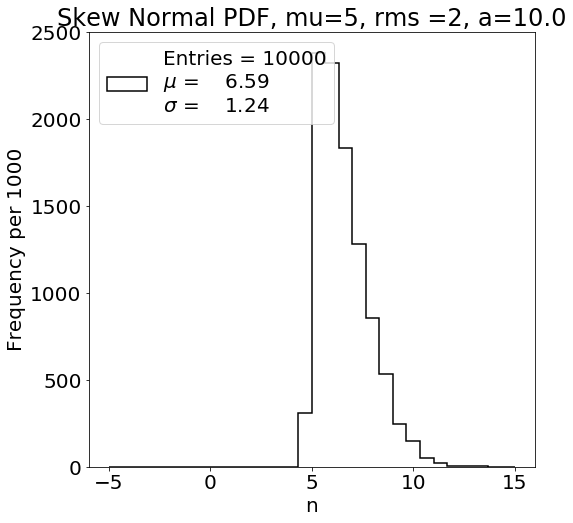

In [31]:
sk19 = sknormal_rvs(mu=5, sigma=2, a=10.0, size=10000)
pl = PlotLabels(x="n", y="Frequency per 1000", title=f'Skew Normal PDF, mu=5, rms =2, a=10.0')
n, b, mu, std = h1d(sk19, bins = 30, range =(-5,15), pltLabels=pl, stats= True, 
                    legendloc='upper left', figsize=(8,8))

# Modeling C19

# Parameters

In [32]:
@dataclass
class EParm:
    """Defines the parameters of an epidemics"""
    r0     : float  # basic reproductive number
    k      : float  # heterogeneity parameter
    ti     : float  # incubation time
    tirms  : float  # incubation time rms
    td     : float  # delay from onset of symptons to isolation
    tdrms  : float  # rms of td
    a      : float  # skew parameter, controlling the proportion of transmission before sympton onset
    c      : float  # mitigation factor => R0' = R0 (1-c)

@dataclass
class TSeries:
    """Time series of an epidemics"""
    tim : np.array  # incubation time average 
    td  : np.array  # delay from onset to isolation 
    tr  : np.array  # time from infection to isolation 
    ti  : np.array  # time of infection propagation
    ts  : np.array  # tr -ti
    

In [33]:
# www.thelancet.com/lancetgh Published online February 28, 2020 https://doi.org/10.1016/S2214-109X(20)30074-7
1
c19 = EParm(r0=2.5, k=0.16, ti = 5.8, tirms = 2.6, td = 8.1, tdrms = 2.7, a = 1, c=0) # unmitigated

In [34]:
c19

EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0)

In [35]:
def istep_r0_only(n0, epar, debug=False):
    """Infection step: 
       - n0 is the initial number of infected
       - epar defines the parameters of infection
       - returns the time series of the infections
    """
    r0e  = epar.r0 * (1 - epar.c)
    if debug:
        print(f' r0  = {epar.r0}. c = {epar.c}, r0e = {r0e}')
    ncl  = c19_nbinom_rvs(r0=r0e, k=epar.k, size=n0) 
    ncs  = sum(ncl)
    
    if debug:
        print(f' number of cases = {ncs}')

    return ncs
    

In [36]:
def istep(n0, epar, debug=False):
    """Infection step: 
       - n0 is the initial number of infected
       - epar defines the parameters of infection
       - returns the time series of the infections
    """
    r0e  = epar.r0 * (1 - epar.c)
    if debug:
        print(f' r0  = {epar.r0}. c = {epar.c}, r0e = {r0e}')
    ncl  = c19_nbinom_rvs(r0=r0e, k=epar.k, size=n0) 
    ncs = sum(ncl)
    tim = c19_weib_rvs(mu=epar.ti, rms=epar.tirms, size=ncs) # average incubation time
    td = c19_weib_rvs(mu=epar.td, rms=epar.tdrms, size=ncs)  # delay from onset
    tr = np.add(tim, td) # isolation at time = tincubation + tonset
    ti  = np.array([sknormal_rvs(mu=t, sigma=2, a=epar.a) for t in tim])  # time of potential transmission.
    ts = np.subtract(tr, ti)  # ti < td => td - ti > 0
    
    if debug:
        print(f' number of cases = {ncs}')
        print(f' incubation time average        tim = {tim}')
        print(f' delay from onset to isolation  td  = {td}')
        print(f' time to isolation              tr  = {tr}')
        print(f' time of infection propagation  ti  = {ti}')
        print(f'                           tr - ti  = {ts}')

    return TSeries(tim,td,tr,ti, ts[ts>0])
    

In [37]:
def fistep(ntrial, n0, epar, debug=False):
    """First infection step returns the infection series and times corresponding
    to Ntrials of the first infection step 
    when the starting number of infected is N0 
    
    """
    TIM = np.zeros(1)
    TD  = np.zeros(1)
    TR  = np.zeros(1)
    TI  = np.zeros(1)
    TS  = np.zeros(1)
    IF  = []
    for i in range(ntrial):
        if(debug):
            print(f' trial = {i}')
        tS = istep(n0, epar, debug)
        IF.append(len(tS.ts))   
        if len(tS.ts) > 0:
            TIM = np.concatenate((TIM, tS.tim))
            TD  = np.concatenate((TD, tS.td))
            TR  = np.concatenate((TR, tS.tr))
            TI  = np.concatenate((TI, tS.ti))
            TS  = np.concatenate((TS, tS.ts))
    return IF, TSeries(TIM,TD,TR,TI,TS)
            
        

In [38]:
fis, tF = fistep(1000, 1, c19, debug=False)

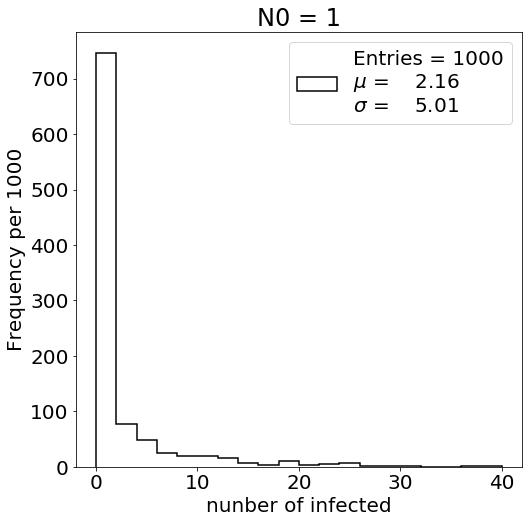

In [39]:
pl = PlotLabels(x="nunber of infected", y="Frequency per 1000", title=f'N0 = 1')
n, b, mu, std = h1d(fis, bins = 20, range =(0,40), pltLabels=pl, stats= True, 
                    legendloc='best', figsize=(8,8))

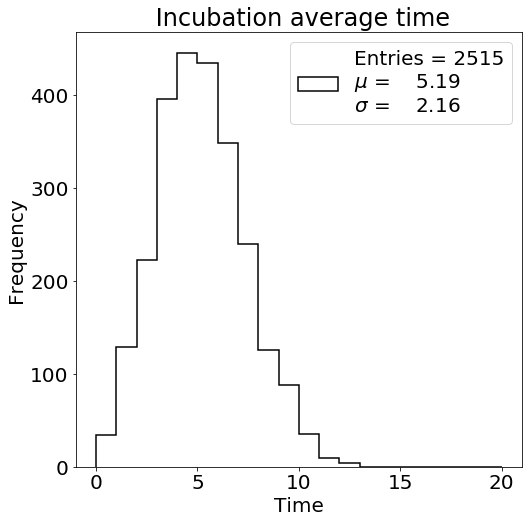

In [40]:
pl = PlotLabels(x="Time", y="Frequency", title=f' Incubation average time')
n, b, mu, std = h1d(tF.tim, bins = 20, range =(0,20), pltLabels=pl, stats= True, 
                    legendloc='best', figsize=(8,8))

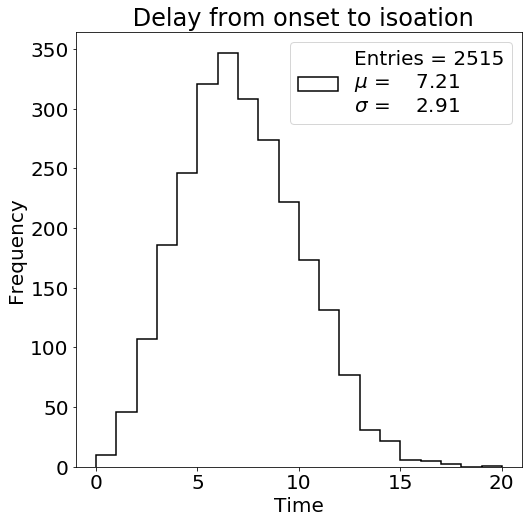

In [41]:
pl = PlotLabels(x="Time", y="Frequency", title=f' Delay from onset to isoation')
n, b, mu, std = h1d(tF.td, bins = 20, range =(0,20), pltLabels=pl, stats= True, 
                    legendloc='best', figsize=(8,8))

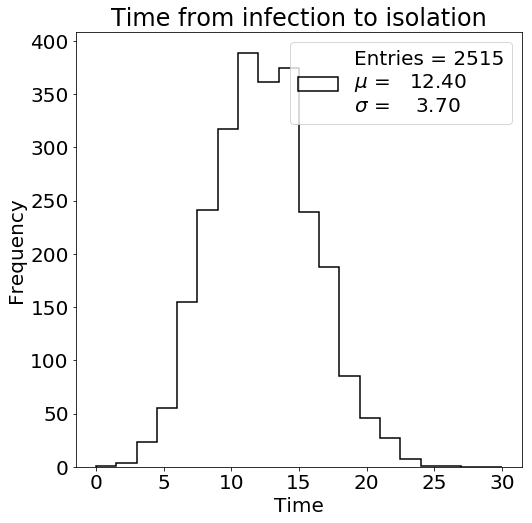

In [42]:
pl = PlotLabels(x="Time", y="Frequency", title=f'Time from infection to isolation')
n, b, mu, std = h1d(tF.tr, bins = 20, range =(0,30), pltLabels=pl, stats= True, 
                    legendloc='best', figsize=(8,8))

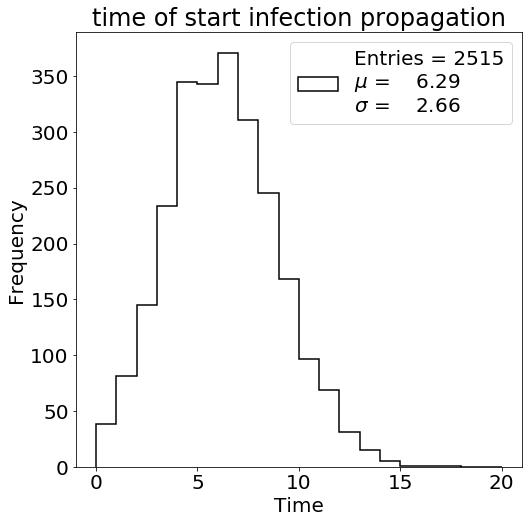

In [43]:
pl = PlotLabels(x="Time", y="Frequency", title=f'time of start infection propagation')
n, b, mu, std = h1d(tF.ti, bins = 20, range =(0,20), pltLabels=pl, stats= True, 
                    legendloc='best', figsize=(8,8))

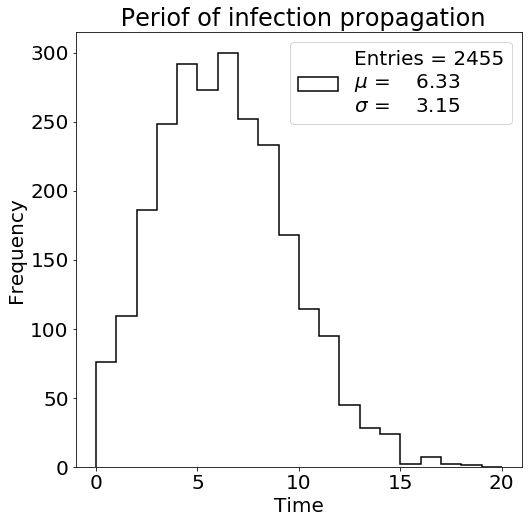

In [44]:
pl = PlotLabels(x="Time", y="Frequency", title=f' Periof of infection propagation')
n, b, mu, std = h1d(tF.ts, bins = 20, range =(0,20), pltLabels=pl, stats= True, 
                    legendloc='best', figsize=(8,8))

In [45]:
fis, tF = fistep(1000, 5, c19, debug=False)

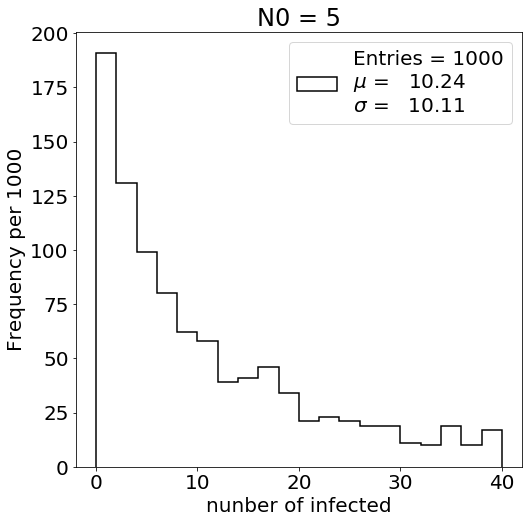

In [46]:
pl = PlotLabels(x="nunber of infected", y="Frequency per 1000", title=f'N0 = 5')
n, b, mu, std = h1d(fis, bins = 20, range =(0,40), pltLabels=pl, stats= True, 
                    legendloc='best', figsize=(8,8))

In [47]:
fis, tF = fistep(1000, 10, c19, debug=False)

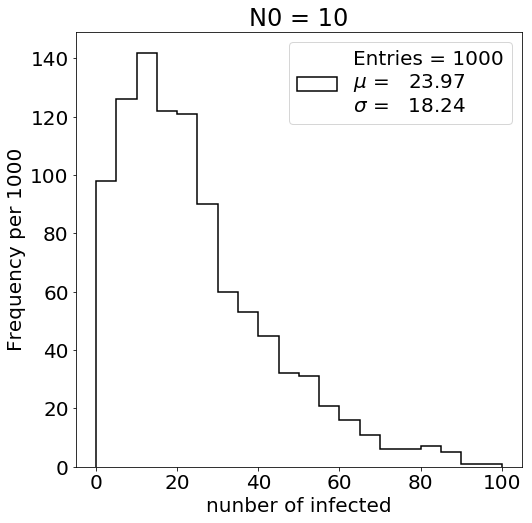

In [48]:
pl = PlotLabels(x="nunber of infected", y="Frequency per 1000", title=f'N0 = 10')
n, b, mu, std = h1d(fis, bins = 20, range =(0,100), pltLabels=pl, stats= True, 
                    legendloc='best', figsize=(8,8))

## Mitigation case

In [49]:
c19 = EParm(r0=2.5, k=0.16, ti = 5.8, tirms = 2.6, td = 8.1, tdrms = 2.7, a = 1, c=0.1) # 10 % mitigation

In [50]:
fis, tF = fistep(1000, 10, c19, debug=False)

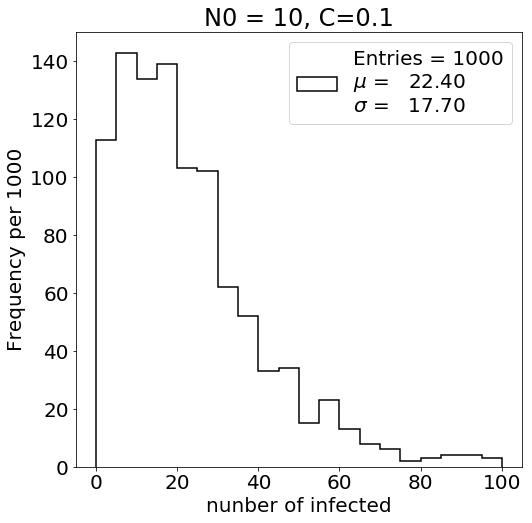

In [51]:
pl = PlotLabels(x="nunber of infected", y="Frequency per 1000", title=f'N0 = 10, C=0.1')
n, b, mu, std = h1d(fis, bins = 20, range =(0,100), pltLabels=pl, stats= True, 
                    legendloc='best', figsize=(8,8))

In [52]:
c19 = EParm(r0=2.5, k=0.16, ti = 5.8, tirms = 2.6, td = 8.1, tdrms = 2.7, a = 1, c=0.5) # 50 % mitigation

In [53]:
fis, tF = fistep(1000, 10, c19, debug=False)

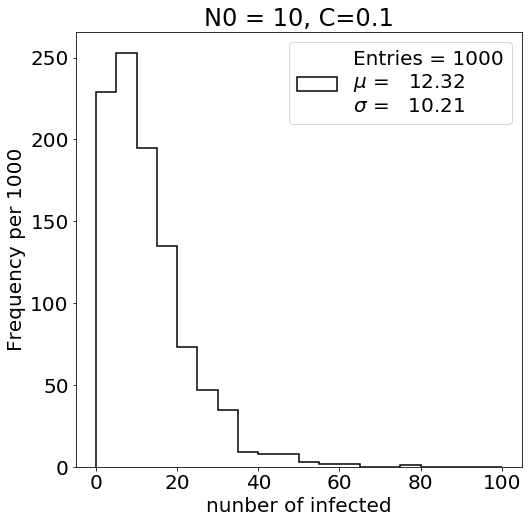

In [54]:
pl = PlotLabels(x="nunber of infected", y="Frequency per 1000", title=f'N0 = 10, C=0.1')
n, b, mu, std = h1d(fis, bins = 20, range =(0,100), pltLabels=pl, stats= True, 
                    legendloc='best', figsize=(8,8))

# Infection evolution 

In [55]:
def ievolution(nsteps, n0, epar, debug=False):
    """Infection evolution after nsteps starting with n0 cases"""
    I = [n0]
    tS = istep(n0, epar)
    nc = len(tS.ts)  # number of cases first infection step
    if debug:
        print(f' first step (i=0), number of cases, nc = {nc}')
    for i in range(1, nsteps):
        I.append(nc) 
        if nc == 0:
            break
        tS = istep(nc, epar)
        nc = len(tS.ts)
        if debug:
            print(f' case i = {i}, nc = {nc}')
    I.append(nc)
    return np.array(I)

def ievolution_r0_only(nsteps, n0, epar, thr=2e+5, debug=False):
    """Infection evolution after nsteps starting with n0 cases"""
    I = [n0]
    nc = istep_r0_only(n0, epar) # number of cases first infection step
    if debug:
        print(f' first step (i=0), number of cases, nc = {nc}')
    for i in range(1, nsteps):
        I.append(nc) 
        if nc == 0 or nc > thr:
            break
        nc = istep_r0_only(nc, epar)
        if debug:
            print(f' case i = {i}, nc = {nc}')
    I.append(nc)
    return np.array(I)


def ievolution__r0_only_global_control(nsteps, asteps, n0, upar, mpar, thr=2e+4, debug=False):
    """Infection evolution starts with n0 cases and has two phases:
       - nsteps unmitiaged with upar evolution
       - asteps mitigated with mpar evolution
       """
    def evol_loop(steps, par, nc, thr):
        for i in range(1, steps):
            I.append(nc) 
            if nc == 0 or nc > thr:
                break
            nc = istep_r0_only(nc, par)
            if debug:
                print(f' case i = {i}, nc = {nc}')
        return nc
    
    I = [n0]
    nc = istep_r0_only(n0, upar)
    if debug:
        print(f' first step (i=0), number of cases, nc = {nc}')
        print(f' start unmitigated loop')
    nc = evol_loop(nsteps, upar, nc, thr)
    I.append(nc)
    if debug:
        print(f' after unmitigated loop, number of cases, nc = {nc}')
    if nc == 0:
        return np.array(I)
    if debug:
        print(f' start mitigated loop')
    nc = evol_loop(asteps, mpar, nc, thr)
    #I.append(nc)

    return np.array(I)


In [56]:
def ievolution__r0_only_global_control_run(ntrials, nsteps, asteps, n0, upar, mpar, thr=2e+4, thrmin = -1,
                                           debug=False):
    IR = []
    for i in range(ntrials):
        if debug:
            print(f'run number {i}')
        imR = ievolution__r0_only_global_control(nsteps, asteps, n0, upar, mpar, thr, debug)
        if imR[-1] > thrmin:
            IR.append(imR)
    return np.array(IR)

In [57]:
def ievolution__r0_only_run(ntrials, nsteps, n0, epar, thr=1e+6, thrmin = 10, debug=False):
    IR = []
    for i in range(ntrials):
        if debug:
            print(f'run number {i}')
        imR = ievolution_r0_only(nsteps, n0, epar, thr, debug)
        if imR[-1] > thrmin:
            IR.append(imR)
    return np.array(IR)

In [58]:
c19uR03   = EParm(r0=3.0, k=0.16, ti = 5.8, tirms = 2.6, td = 8.1, tdrms = 2.7, a = 1, c=0.) # 0 % mitigation
c19uR01d8 = EParm(r0=1.8, k=0.16, ti = 5.8, tirms = 2.6, td = 8.1, tdrms = 2.7, a = 1, c=0.)
c19uR01d3 = EParm(r0=1.3, k=0.16, ti = 5.8, tirms = 2.6, td = 8.1, tdrms = 2.7, a = 1, c=0.)
c19uR01d5 = EParm(r0=1.5, k=0.16, ti = 5.8, tirms = 2.6, td = 8.1, tdrms = 2.7, a = 1, c=0.)

In [59]:
c19uR03c2   = EParm(r0=3.0, k=0.16, ti = 5.8, tirms = 2.6, td = 8.1, tdrms = 2.7, a = 1, c=0.2)
c19uR03c4   = EParm(r0=3.0, k=0.16, ti = 5.8, tirms = 2.6, td = 8.1, tdrms = 2.7, a = 1, c=0.4)
c19uR03c6   = EParm(r0=3.0, k=0.16, ti = 5.8, tirms = 2.6, td = 8.1, tdrms = 2.7, a = 1, c=0.6)
c19uR03c8   = EParm(r0=3.0, k=0.16, ti = 5.8, tirms = 2.6, td = 8.1, tdrms = 2.7, a = 1, c=0.7)

In [60]:
IMR03c2 = ievolution__r0_only_global_control_run(ntrials=30, nsteps=6, asteps=20, 
                                                 n0=1, upar=c19uR03, mpar=c19uR03c2, 
                                                 thr=1e+5, debug=False)

In [61]:
IMR03c4 = ievolution__r0_only_global_control_run(ntrials=30, nsteps=6, asteps=20, 
                                                 n0=1, upar=c19uR03, mpar=c19uR03c4, 
                                                 thr=1e+5, debug=False)

In [62]:
IMR03c6 = ievolution__r0_only_global_control_run(ntrials=30, nsteps=6, asteps=20, 
                                                 n0=1, upar=c19uR03, mpar=c19uR03c6, 
                                                 thr=1e+5, debug=False)

In [63]:
IMR03c8 = ievolution__r0_only_global_control_run(ntrials=30, nsteps=6, asteps=20, 
                                                 n0=1, upar=c19uR03, mpar=c19uR03c8, 
                                                 thr=1e+5, debug=False)

In [64]:
IMR03 = ievolution__r0_only_run(ntrials=100, nsteps=10, n0=1, epar=c19uR03, 
                                thr=1e+6, thrmin = 10,debug=False)

In [65]:
len(IMR03)

25

In [66]:
def plot_evolution_r0_only_i(I,T,figsize=(12,12)):
    fig = plt.figure(figsize=figsize)
    ax  = plt.subplot(1,1,1)
    print(f'fraction of success = {len(I)} %')
    for j, II in enumerate(I): 
        x   = np.arange(len(II))
        ax.plot(x, II, lw=2, alpha=0.6, label=f' infection run ={j}')
    plt.xlabel('tiempo (en unidades arbitrarias)')
    plt.ylabel('número de contagios')
    plt.title(T)
        #plt.legend()
    plt.tight_layout()
    plt.show()

fraction of success = 27 %


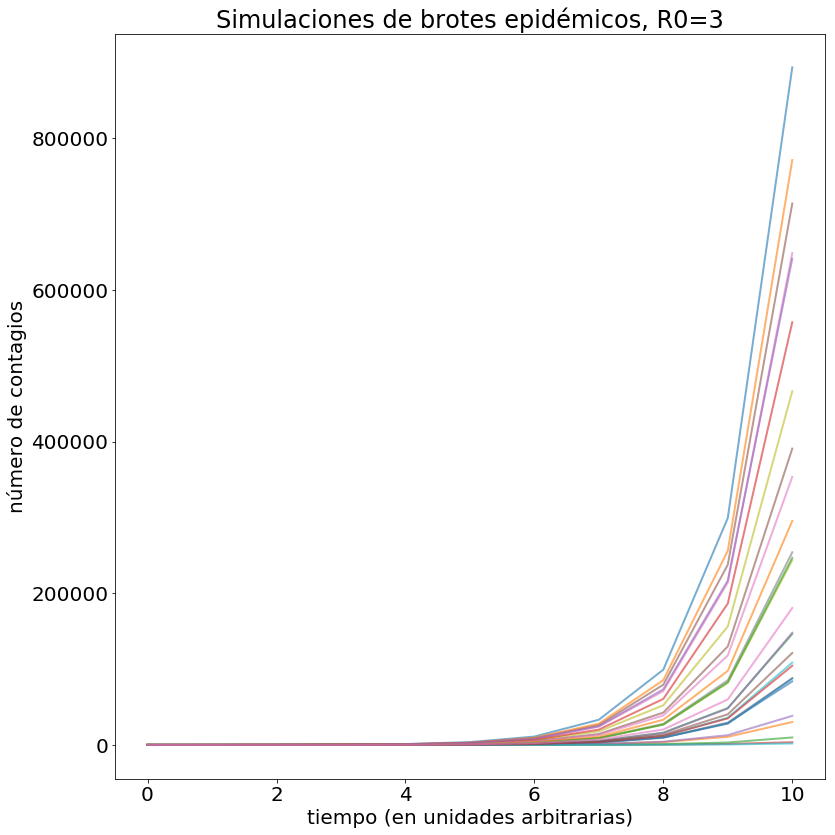

In [792]:
plot_evolution_r0_only_i(IMR03,"Simulaciones de brotes epidémicos, R0=3",figsize=(12,12))

In [67]:
IMR01d8 = ievolution__r0_only_run(ntrials=100, nsteps=10, n0=1, epar=c19uR01d8, 
                                thr=1e+6, thrmin = 10,debug=False)

In [68]:
IMR01d5 = ievolution__r0_only_run(ntrials=100, nsteps=10, n0=1, epar=c19uR01d5, 
                                thr=1e+6, thrmin = 10,debug=False)

In [69]:
IMR01d3 = ievolution__r0_only_run(ntrials=100, nsteps=10, n0=1, epar=c19uR01d5, 
                                thr=1e+6, thrmin = 10,debug=False)

In [70]:
def plot_evolution_r0_only(Is,Ts,figsize=(12,12)):
    fig = plt.figure(figsize=figsize)
    for i, I in enumerate(Is):
        ax  = plt.subplot(2,2,i+1)
        print(f'fraction of success = {len(I)} %')
        for j, II in enumerate(I): 
            x   = np.arange(len(II))
            ax.plot(x, II, lw=2, alpha=0.6, label=f' infection run ={j}')
        plt.xlabel('time steps')
        plt.ylabel('number of cases')
        plt.title(Ts[i])
        #plt.legend()
    plt.tight_layout()
    plt.show()

fraction of success = 25 %
fraction of success = 10 %
fraction of success = 3 %
fraction of success = 8 %


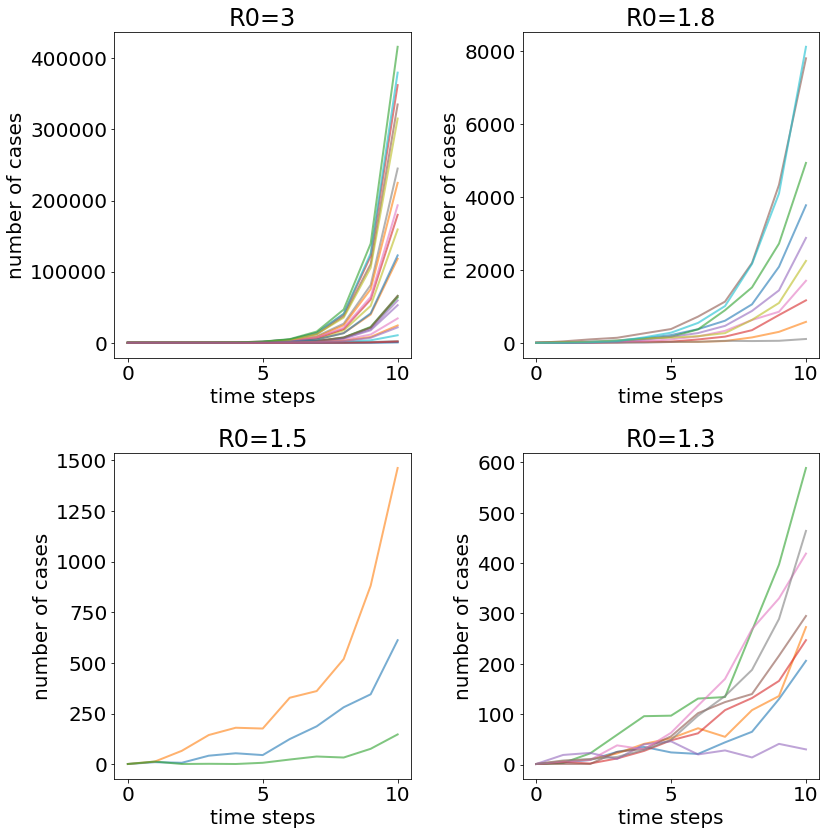

In [71]:
plot_evolution_r0_only((IMR03,IMR01d8,IMR01d5,IMR01d3),('R0=3','R0=1.8','R0=1.5','R0=1.3'),figsize=(12,12))

fraction of success = 30 %
fraction of success = 30 %
fraction of success = 30 %
fraction of success = 30 %


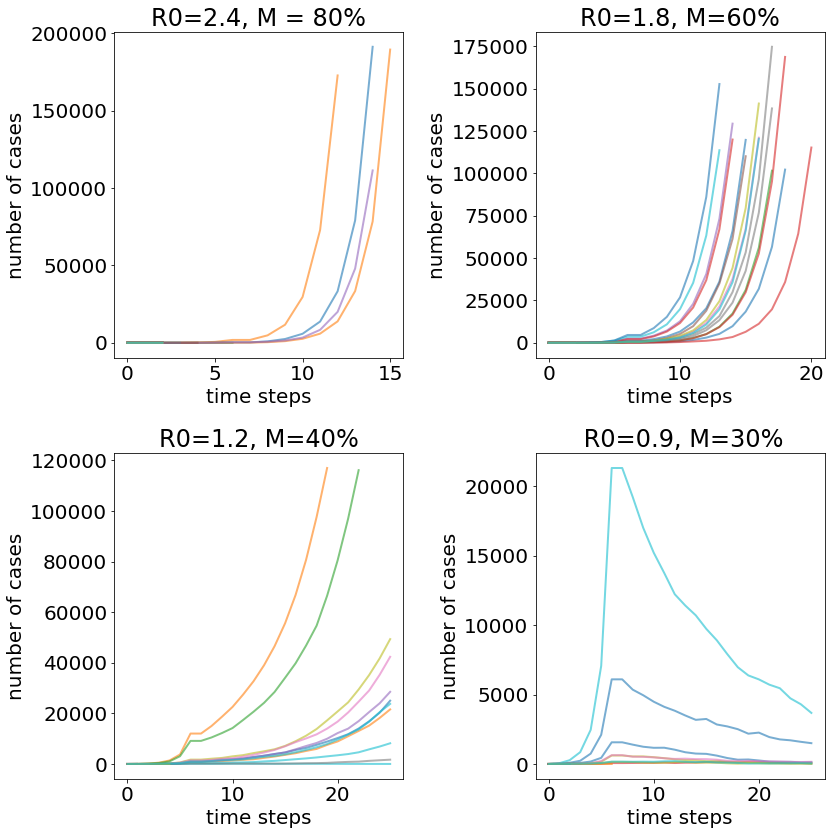

In [72]:
plot_evolution_r0_only((IMR03c2,IMR03c4,IMR03c6,IMR03c8),
                       ('R0=2.4, M = 80%','R0=1.8, M=60%','R0=1.2, M=40%',' R0=0.9, M=30%'),
                       figsize=(12,12))

In [526]:
def isuccess(ntrials, nsteps, n0, epar, thr, debug=False):
    """Estimates infection success, starting with n0 cases after nsteps.
       thr is the treshold for the infection to be successful. 
       Repeat for ntrials
    """
    nfail = 0
    nsc   = 0
    IM    = []
    for i in range(ntrials):
        I = ievolution(nsteps, n0, epar, debug)
        if debug:
            print(f' Infection series I ={I}')

        if I[-1] > thr:
            nsc+=1
            IM.append(I)
        else:
            nfail+=1
    return nsc, nfail, IM
        

In [527]:
nsc, nfail, IM = isuccess(ntrials=10, nsteps=10, n0=1, epar=c19, thr=10, debug=True)

 first step (i=0), number of cases, nc = 0
 Infection series I =[1 0 0]
 first step (i=0), number of cases, nc = 0
 Infection series I =[1 0 0]
 first step (i=0), number of cases, nc = 1
 case i = 1, nc = 6
 case i = 2, nc = 2
 case i = 3, nc = 0
 Infection series I =[1 1 6 2 0 0]
 first step (i=0), number of cases, nc = 0
 Infection series I =[1 0 0]
 first step (i=0), number of cases, nc = 0
 Infection series I =[1 0 0]
 first step (i=0), number of cases, nc = 24
 case i = 1, nc = 30
 case i = 2, nc = 55
 case i = 3, nc = 93
 case i = 4, nc = 220
 case i = 5, nc = 423
 case i = 6, nc = 950
 case i = 7, nc = 2541
 case i = 8, nc = 6094
 case i = 9, nc = 14159
 Infection series I =[    1    24    30    55    93   220   423   950  2541  6094 14159]
 first step (i=0), number of cases, nc = 0
 Infection series I =[1 0 0]
 first step (i=0), number of cases, nc = 14
 case i = 1, nc = 37
 case i = 2, nc = 105
 case i = 3, nc = 254
 case i = 4, nc = 556
 case i = 5, nc = 1202
 case i = 6, nc 

In [528]:
IM

[array([    1,    24,    30,    55,    93,   220,   423,   950,  2541,
         6094, 14159]),
 array([    1,    14,    37,   105,   254,   556,  1202,  2942,  7328,
        18655, 45195]),
 array([  1,   3,   8,   3,  21,  11,  29,  35,  70, 164, 419])]

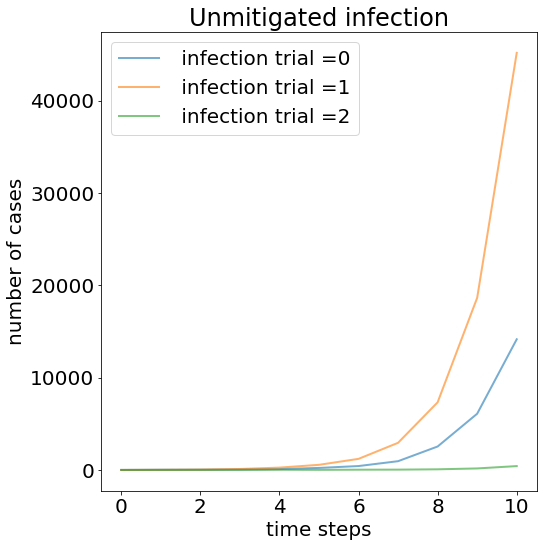

In [530]:
fig = plt.figure(figsize=(8,8))
ax  = plt.subplot(111)
x   = np.arange(len(IM[0]))
for i, I in enumerate(IM):   
    ax.plot(x, I, lw=2, alpha=0.6, label=f' infection trial ={i}')
plt.xlabel('time steps')
plt.ylabel('number of cases')
plt.title('Unmitigated infection')
plt.legend()
plt.tight_layout()
plt.show()

In [646]:
def ievolution_global_control(nsteps, asteps, n0, upar, mpar, thr=1e+5, debug=False):
    """Infection evolution starts with n0 cases and has two phases:
       - nsteps unmitiaged with upar evolution
       - asteps mitigated with mpar evolution
       """
    def evol_loop(steps, par, nc, thr):
        for i in range(1, steps):
            I.append(nc) 
            if nc == 0 or nc > thr:
                break
            tS = istep(nc, par)
            nc = len(tS.ts)
            if debug:
                print(f' case i = {i}, nc = {nc}')
        return nc
    
    print(upar)
    print(mpar)
    I = [n0]
    tS = istep(n0, upar)
    nc = len(tS.ts)  # number of cases first infection step
    if debug:
        print(f' first step (i=0), number of cases, nc = {nc}')
        print(f' start unmitigated loop')
    nc = evol_loop(nsteps, upar, nc, thr)
    I.append(nc)
    if debug:
        print(f' after unmitigated loop, number of cases, nc = {nc}')
    if nc == 0:
        return np.array(I)
    if debug:
        print(f' start mitigated loop')

    nc = evol_loop(asteps, mpar, nc, thr)
    I.append(nc)

    return np.array(I)


In [633]:
c19u = EParm(r0=2.5, k=0.16, ti = 5.8, tirms = 2.6, td = 8.1, tdrms = 2.7, a = 1, c=0.) # 0 % mitigation
c19m20 = EParm(r0=2.5, k=0.16, ti = 5.8, tirms = 2.6, td = 8.1, tdrms = 2.7, a = 1, c=0.2) # 20 % mitigation
c19m40 = EParm(r0=2.5, k=0.16, ti = 5.8, tirms = 2.6, td = 8.1, tdrms = 2.7, a = 1, c=0.4) # 40 % mitigation
c19m60 = EParm(r0=2.5, k=0.16, ti = 5.8, tirms = 2.6, td = 8.1, tdrms = 2.7, a = 1, c=0.6) # 60 % mitigation
c19m80 = EParm(r0=2.5, k=0.16, ti = 5.8, tirms = 2.6, td = 8.1, tdrms = 2.7, a = 1, c=0.8) # 60 % mitigation

In [612]:
c19u

EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.0)

In [613]:
c19m20

EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.2)

In [617]:
IM20= []
for i in range(10):
    Im20 = ievolution_global_control(nsteps=10, asteps=10, n0=1, upar=c19u, mpar=c19m20,  debug=True)
    IM20.append(Im20)

EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.0)
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.2)
 first step (i=0), number of cases, nc = 0
 start unmitigated loop
 after unmitigated loop, number of cases, nc = 0
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.0)
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.2)
 first step (i=0), number of cases, nc = 0
 start unmitigated loop
 after unmitigated loop, number of cases, nc = 0
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.0)
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.2)
 first step (i=0), number of cases, nc = 0
 start unmitigated loop
 after unmitigated loop, number of cases, nc = 0
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.0)
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.2)
 first step (i=0), number of cases, nc = 5
 start unmitigated loop
 case i =

In [618]:
IM20

[array([1, 0, 0]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([     1,      5,      6,     46,    120,    298,    713,   1725,
          4367,  10975,  27337,  27337,  52574, 103938, 103938]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([1, 1, 0, 0]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([1, 0, 0])]

In [627]:
im20 = IM20[3]

In [628]:
im20

array([     1,      5,      6,     46,    120,    298,    713,   1725,
         4367,  10975,  27337,  27337,  52574, 103938, 103938])

In [620]:
IM40= []
for i in range(10):
    Im40 = ievolution_global_control(nsteps=8, asteps=10, n0=1, upar=c19u, mpar=c19m40,  debug=True)
    IM40.append(Im40)

EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.0)
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.4)
 first step (i=0), number of cases, nc = 15
 start unmitigated loop
 case i = 1, nc = 51
 case i = 2, nc = 114
 case i = 3, nc = 359
 case i = 4, nc = 930
 case i = 5, nc = 2419
 case i = 6, nc = 5841
 case i = 7, nc = 14180
 after unmitigated loop, number of cases, nc = 14180
 start mitigated loop
 case i = 1, nc = 21207
 case i = 2, nc = 29978
 case i = 3, nc = 43797
 case i = 4, nc = 63220
 case i = 5, nc = 93488
 case i = 6, nc = 134737
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.0)
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.4)
 first step (i=0), number of cases, nc = 1
 start unmitigated loop
 case i = 1, nc = 0
 after unmitigated loop, number of cases, nc = 0
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.0)
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7,

In [629]:
IM40

[array([     1,     15,     51,    114,    359,    930,   2419,   5841,
         14180,  14180,  21207,  29978,  43797,  63220,  93488, 134737,
        134737]),
 array([1, 1, 0, 0]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([     1,      6,     17,     55,    120,    222,    528,   1319,
          3389,   3389,   5090,   7497,  10965,  16273,  23776,  34914,
         50710,  74380, 107129]),
 array([1, 0, 0])]

In [631]:
IM60= []
for i in range(10):
    Im60 = ievolution_global_control(nsteps=10, asteps=20, n0=1, upar=c19u, mpar=c19m60,  debug=True)
    IM60.append(Im60)

EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.0)
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.6)
 first step (i=0), number of cases, nc = 0
 start unmitigated loop
 after unmitigated loop, number of cases, nc = 0
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.0)
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.6)
 first step (i=0), number of cases, nc = 0
 start unmitigated loop
 after unmitigated loop, number of cases, nc = 0
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.0)
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.6)
 first step (i=0), number of cases, nc = 0
 start unmitigated loop
 after unmitigated loop, number of cases, nc = 0
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.0)
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.6)
 first step (i=0), number of cases, nc = 0
 start unmitigated loop
 after un

In [632]:
IM60

[array([1, 0, 0]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([    1,     8,    36,    49,   111,   188,   635,  1835,  4205,
        10085, 24568, 24568, 23970, 23651, 22528, 21147, 20775, 19398,
        18734, 18246, 16941, 15993, 15275, 15304, 14274, 13714, 13185,
        12763, 12372, 12733, 12738]),
 array([1, 4, 3, 0, 0]),
 array([   1,    8,   12,   43,   63,  102,  183,  449, 1127, 2878, 6420,
        6420, 6051, 5531, 5585, 5463, 5236, 5135, 5008, 4927, 4674, 4630,
        4661, 4509, 4515, 4287, 4093, 3964, 3937, 3780, 3706]),
 array([1, 0, 0]),
 array([1, 0, 0])]

In [635]:
IM80= []
for i in range(10):
    Im80 = ievolution_global_control(nsteps=10, asteps=20, n0=1, upar=c19u, mpar=c19m80,  debug=True)
    IM80.append(Im80)

EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.0)
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.8)
 first step (i=0), number of cases, nc = 2
 start unmitigated loop
 case i = 1, nc = 35
 case i = 2, nc = 103
 case i = 3, nc = 312
 case i = 4, nc = 826
 case i = 5, nc = 1880
 case i = 6, nc = 5203
 case i = 7, nc = 12835
 case i = 8, nc = 31281
 case i = 9, nc = 75575
 after unmitigated loop, number of cases, nc = 75575
 start mitigated loop
 case i = 1, nc = 36544
 case i = 2, nc = 18007
 case i = 3, nc = 8855
 case i = 4, nc = 4330
 case i = 5, nc = 2280
 case i = 6, nc = 1143
 case i = 7, nc = 588
 case i = 8, nc = 283
 case i = 9, nc = 182
 case i = 10, nc = 70
 case i = 11, nc = 28
 case i = 12, nc = 16
 case i = 13, nc = 5
 case i = 14, nc = 2
 case i = 15, nc = 2
 case i = 16, nc = 0
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.0)
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.8)
 first st

In [642]:
c19m60s = EParm(r0=2.5, k=0.16, ti = 5.8, tirms = 2.6, td = 1, tdrms = 1.0, a = 1, c=0.6) # 60 % mitigation

In [649]:
IM60s= []
for i in range(20):
    Im60s = ievolution_global_control(nsteps=10, asteps=20, n0=1, upar=c19u, mpar=c19m60s, thr=1.5e+5,
                                      debug=True)
    IM60s.append(Im60s)

EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.0)
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=1, tdrms=1.0, a=1, c=0.6)
 first step (i=0), number of cases, nc = 0
 start unmitigated loop
 after unmitigated loop, number of cases, nc = 0
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.0)
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=1, tdrms=1.0, a=1, c=0.6)
 first step (i=0), number of cases, nc = 0
 start unmitigated loop
 after unmitigated loop, number of cases, nc = 0
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.0)
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=1, tdrms=1.0, a=1, c=0.6)
 first step (i=0), number of cases, nc = 0
 start unmitigated loop
 after unmitigated loop, number of cases, nc = 0
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=8.1, tdrms=2.7, a=1, c=0.0)
EParm(r0=2.5, k=0.16, ti=5.8, tirms=2.6, td=1, tdrms=1.0, a=1, c=0.6)
 first step (i=0), number of cases, nc = 1
 start unmitigated loop
 case i = 1, nc =

In [650]:
IM60s

[array([1, 0, 0]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([1, 1, 0, 0]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([     1,      5,     73,    186,    454,   1248,   3095,   7381,
         18419,  43750, 106576, 106576,  48856,  22258,  10349,   4999,
          2371,   1128,    547,    226,    125,     67,     52,     12,
             3,      0,      0]),
 array([1, 2, 1, 0, 0]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([    1,    12,    25,    45,    98,   233,   634,  1675,  4516,
        11199, 26832, 26832, 12346,  5537,  2624,  1101,   483,   238,
           99,    61,    17,     8,    10,     7,     2,     0,     0]),
 array([1, 0, 0])]

In [651]:
im60s = IM60s[9]

In [656]:
im60s2 = np.delete(im60s, 10)

In [657]:
im60s2

array([     1,      5,     73,    186,    454,   1248,   3095,   7381,
        18419,  43750, 106576,  48856,  22258,  10349,   4999,   2371,
         1128,    547,    226,    125,     67,     52,     12,      3,
            0,      0])

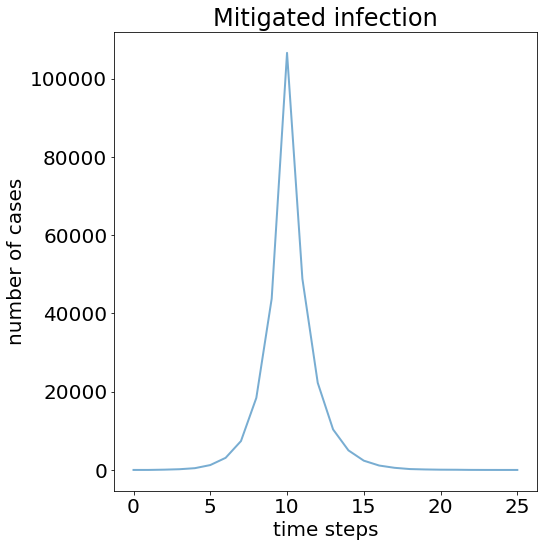

In [659]:
fig = plt.figure(figsize=(8,8))
ax  = plt.subplot(111)
x   = np.arange(len(im60s2)) 
ax.plot(x, im60s2, lw=2, alpha=0.6, label=f' mitigated infection')
plt.xlabel('time steps')
plt.ylabel('number of cases')
plt.title('Mitigated infection')
#plt.legend()
plt.tight_layout()
plt.show()